JSON logs with images: 31562
              type                   timestamp      user              ip  \
0         standard  2024-12-01T14:29:09.181812  user_502   141.11.96.144   
1  json_with_image  2024-12-01T16:20:41.181812  user_152   196.56.235.78   
2         standard  2024-11-30T18:08:41.199997  user_519    170.107.5.52   
3         standard  2024-12-02T08:32:55.199997  user_577     60.83.64.21   
4         standard  2024-12-01T13:23:24.199997  user_970  130.147.155.12   

  action  event                                            details  \
0  START    NaN                                                NaN   
1    NaN  error  {'item_id': 7290, 'quantity': 3, 'price': 270.26}   
2  START    NaN                                                NaN   
3  ERROR    NaN                                                NaN   
4  START    NaN                                                NaN   

                                    iot_device_image  
0                                     

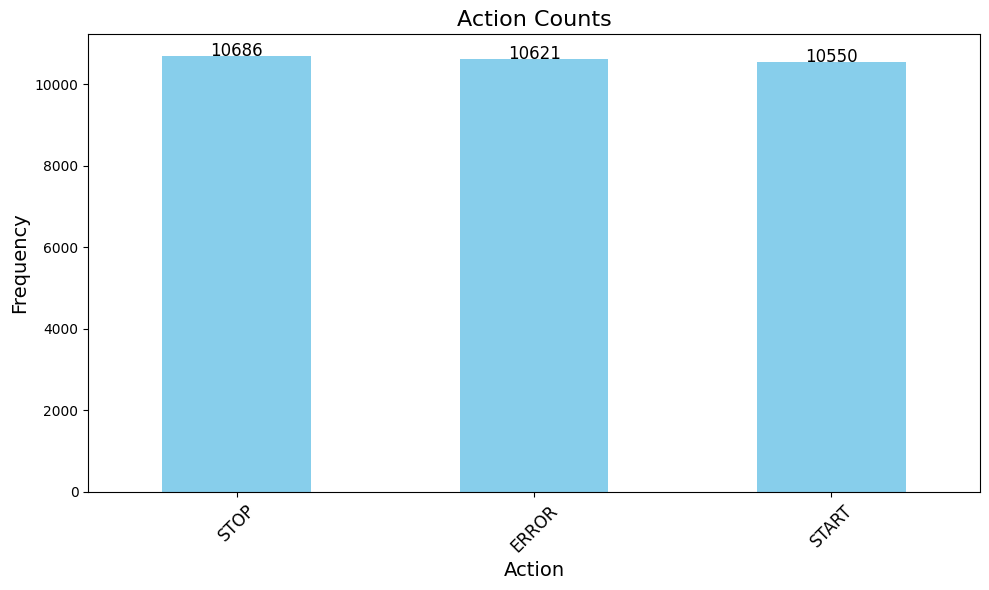

In [ ]:
import re
import json
import pandas as pd
from base64 import b64decode
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

structured_data = []
unknown_logs = []
errors = []
all_json_data = []
# Function to parse log entries
def parse_log_entry(entry):
    # Matching standard log entries
    standard_pattern = re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+) user=(?P<user>\w+) ip=(?P<ip>[0-9\.]+) action=(?P<action>\w+)')
    match = standard_pattern.match(entry)
    if match:
        return {"type": "standard", **match.groupdict()}
    
    try:
        json_data = json.loads(entry)
        if "iot_device_image" in json_data:
            json_data["type"] = "json_with_image"
        return json_data
    except json.JSONDecodeError:
        pass

    # Malformed entries or unstructured logs
    if "MALFORMED_LOG_ENTRY" in entry or "Exception" in entry or "Error" in entry or "Malformed JSON object" in entry or "InvalidBase64" in entry:
        return {"type": "error", "content": entry.strip()}
    
    return {"type": "unknown", "content": entry.strip()}

# Function to decode Base64 images
def decode_base64_image(encoded_str, output_path):
    try:
        image_data = b64decode(encoded_str.split(",")[1])  # Extracting Base64 data from the string
        image = Image.open(BytesIO(image_data))
        # image.save(output_path)
    except Exception as e:
        print(f"Error decoding image: {e}")

# Function to process the log file
def process_log_file(file_path):
    cnt = 1
    global structured_data, unknown_logs, errors
    json_with_image_count = 0
    with open(file_path, 'r') as file:
        for line in file:
            cnt += 1
            parsed = parse_log_entry(line)
            if parsed["type"] == "standard" or parsed["type"] == "json" or parsed["type"] == "json_with_image":
                structured_data.append(parsed)
                if parsed["type"] == "json_with_image":
                    all_json_data.append(parsed)
                    # Decode the image and save it
                    json_with_image_count += 1
                    decode_base64_image(parsed["iot_device_image"], f"decoded_image_{cnt}.png")
            elif parsed["type"] == "error":
                errors.append(parsed["content"])
            else:
                unknown_logs.append(parsed["content"])
    print(f"JSON logs with images: {json_with_image_count}")

# Function to visualize the data
def visualize_data(df):
    action_counts = df['action'].value_counts()
    plt.figure(figsize=(10, 6))

    # bar chart
    ax = action_counts.plot(kind='bar', color='skyblue')
    plt.title('Action Counts', fontsize=16)
    plt.xlabel('Action', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    for index, value in enumerate(action_counts):
        plt.text(index, value + 1, str(value), ha='center', fontsize=12, color='black')

    plt.xticks(rotation=45, fontsize=12) 
    plt.tight_layout() 
    plt.show()

# File path for the log
file_path = 'assignment_prod.log'

# Processing the log file
process_log_file(file_path)

# Converting structured data into a Pandas DataFrame
df = pd.DataFrame(structured_data)

# Displaying structured data
print(df.head(5), df.shape)

# Visualizing action counts from structured data
visualize_data(df)

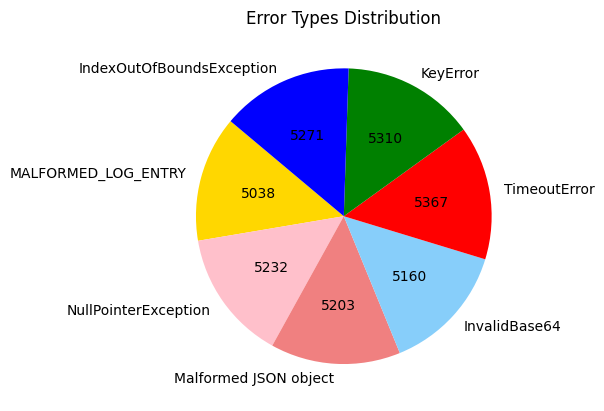

In [8]:
import matplotlib.pyplot as plt
errors_count = {"MALFORMED_LOG_ENTRY" : 0, "NullPointerException" : 0, "Malformed JSON object" : 0, "InvalidBase64" : 0, "TimeoutError" : 0, "KeyError" : 0, "IndexOutOfBoundsException" : 0}
for error in errors:
    flag = False
    for s in errors_count:
        if error.startswith(s):
            errors_count[s] += 1
            flag = True
            break
    if not flag:
        print(error)

tot = sum(errors_count.values())
values = [val / tot for val in errors_count.values()]
entries = list(errors_count.keys())
colors = ['gold', 'pink', 'lightcoral', 'lightskyblue', 'red', 'green', 'blue']

def custom_autopct(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f"{absolute}"

# pie chart
plt.pie(
    values,
    labels=entries,
    colors=colors,
    autopct=lambda pct: custom_autopct(pct, list(errors_count.values())),
    startangle=140
)

plt.title('Error Types Distribution')

plt.show()

In [9]:
from pprint import pprint
users_details = []
for name, group in df.groupby('user'):
    this_user = {"name": name, "details": {}}
    items_details = this_user["details"]
    for map in group["details"]:
        if pd.isnull(map):
            continue
        if map["item_id"] in items_details:
            items_details[map["item_id"]]["tot_price"] += map["quantity"] * map["price"]
            items_details[map["item_id"]]["tot_quantity"] += map["quantity"]
        else:
            items_details[map["item_id"]] = {"tot_price": map["quantity"] * map["price"], "tot_quantity": map["quantity"]}
    users_details.append(this_user)
pprint(users_details)

[{'details': {1053: {'tot_price': 291.09, 'tot_quantity': 1},
              1100: {'tot_price': 4980.0, 'tot_quantity': 5},
              1115: {'tot_price': 885.58, 'tot_quantity': 1},
              1469: {'tot_price': 1981.86, 'tot_quantity': 2},
              1846: {'tot_price': 2320.02, 'tot_quantity': 3},
              1881: {'tot_price': 4624.049999999999, 'tot_quantity': 5},
              2052: {'tot_price': 2529.08, 'tot_quantity': 4},
              2111: {'tot_price': 671.56, 'tot_quantity': 4},
              2706: {'tot_price': 2752.32, 'tot_quantity': 3},
              3618: {'tot_price': 3302.3500000000004, 'tot_quantity': 5},
              4091: {'tot_price': 2566.75, 'tot_quantity': 5},
              4455: {'tot_price': 886.22, 'tot_quantity': 2},
              4832: {'tot_price': 1874.9, 'tot_quantity': 2},
              5036: {'tot_price': 562.59, 'tot_quantity': 3},
              5056: {'tot_price': 1885.2, 'tot_quantity': 4},
              5096: {'tot_price': 2882.43,

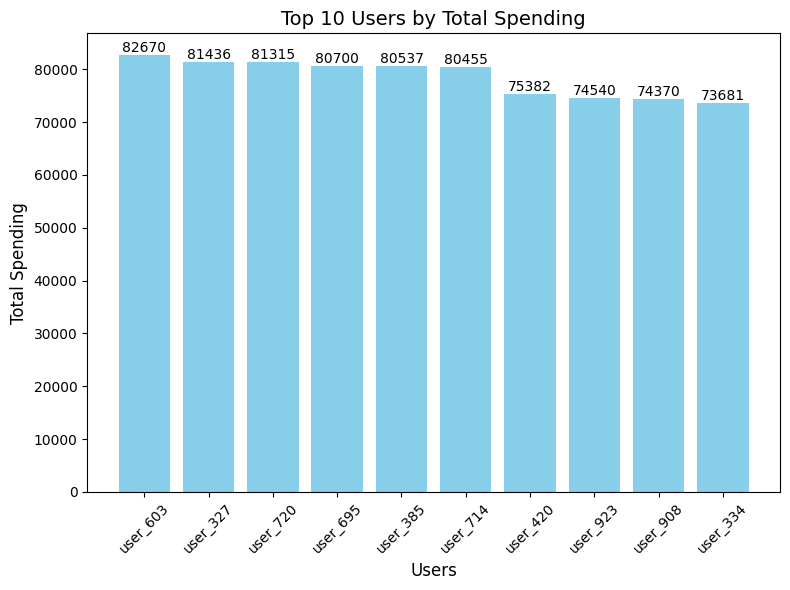

In [10]:
top_users = []
for user in users_details:
    total_price = sum(item["tot_price"] for item in user["details"].values())
    top_users.append({"name": user["name"], "total_price": total_price})

k = 10  # Number of top users to display
top_users = sorted(top_users, key=lambda x: x["total_price"], reverse=True)[:k]

# names and spending for the bar chart
user_names = [u["name"] for u in top_users]
user_spending = [u["total_price"] for u in top_users]

# bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(user_names, user_spending, color="skyblue")

for bar, spending in zip(bars, user_spending):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        bar.get_height(),
        f"{int(spending)}",
        ha="center",
        va="bottom", 
        fontsize=10,
        color="black"
    )

plt.title(f"Top {k} Users by Total Spending", fontsize=14)
plt.xlabel("Users", fontsize=12)
plt.ylabel("Total Spending", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

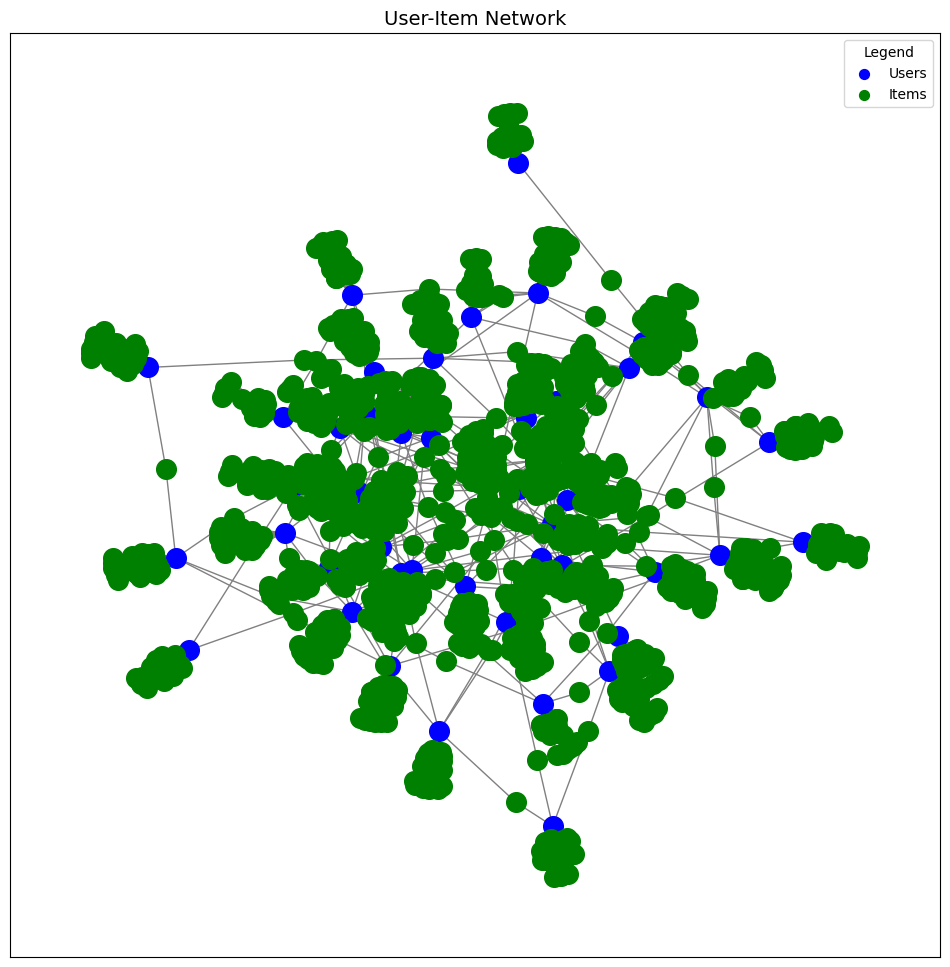

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for user in users_details[:50]:  # Limit to the first 50 users for clarity
    user_name = user["name"]
    G.add_node(user_name, type="user") 
    for item_id, item_details in user["details"].items():
        item_name = f"Item {item_id}"
        G.add_node(item_name, type="item")  
        G.add_edge(user_name, item_name, weight=item_details["tot_quantity"]) 

# graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

# nodes and edges
user_nodes = [n for n in G.nodes if G.nodes[n]["type"] == "user"]
item_nodes = [n for n in G.nodes if G.nodes[n]["type"] == "item"]

nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color="blue", label="Users", node_size=200)
nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color="green", label="Items", node_size=200)
nx.draw_networkx_edges(G, pos, edge_color="gray")

# legend
plt.legend(
    loc="upper right",
    scatterpoints=1,
    fontsize=10,
    title="Legend",
    frameon=True,
    markerscale=0.5,
)

# title
plt.title("User-Item Network", fontsize=14)
plt.show()


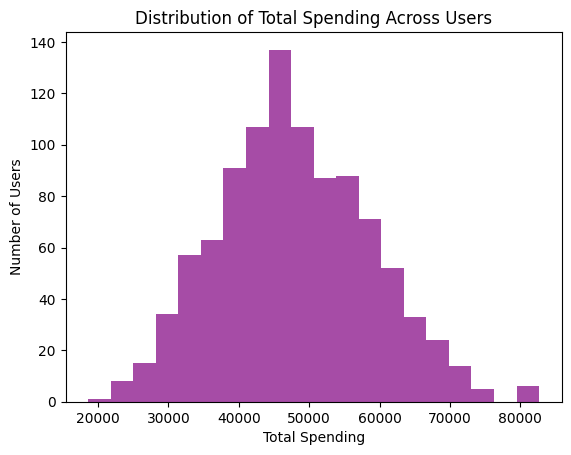

In [ ]:
# Total spending for all users
spending_distribution = [sum(item["tot_price"] for item in user["details"].values()) for user in users_details]

# Histogram
plt.hist(spending_distribution, bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Total Spending Across Users")
plt.xlabel("Total Spending")
plt.ylabel("Number of Users")
plt.show()


[171.0, 178.0, 209.0, 149.0, 236.0, 145.0, 174.0, 187.0, 145.0, 199.0, 190.0, 202.0, 200.0, 169.0, 158.0, 149.0, 138.0, 159.0, 152.0, 144.0, 171.0, 209.0, 206.0, 135.0, 151.0, 161.0, 172.0, 196.0, 133.0, 187.0, 160.0, 144.0, 175.0, 171.0, 227.0, 155.0, 165.0, 151.0, 146.0, 165.0, 165.0, 192.0, 174.0, 167.0, 170.0, 183.0, 167.0, 152.0, 176.0, 151.0, 190.0, 189.0, 155.0, 146.0, 149.0, 198.0, 153.0, 180.0, 140.0, 171.0, 182.0, 148.0, 182.0, 218.0, 158.0, 156.0, 179.0, 181.0, 171.0, 189.0, 184.0, 167.0, 190.0, 161.0, 149.0, 178.0, 173.0, 164.0, 210.0, 136.0, 177.0, 186.0, 196.0, 125.0, 172.0, 176.0, 165.0, 175.0, 160.0, 151.0, 165.0, 124.0, 155.0, 171.0, 220.0, 247.0, 203.0, 150.0, 161.0, 180.0, 191.0, 197.0, 158.0, 172.0, 175.0, 188.0, 173.0, 164.0, 112.0, 205.0, 172.0, 161.0, 200.0, 183.0, 138.0, 165.0, 182.0, 177.0, 163.0, 189.0, 161.0, 166.0, 164.0, 158.0, 169.0, 190.0, 164.0, 127.0, 163.0, 131.0, 173.0, 152.0, 172.0, 135.0, 135.0, 131.0, 132.0, 158.0, 153.0, 178.0, 177.0, 172.0, 174.0

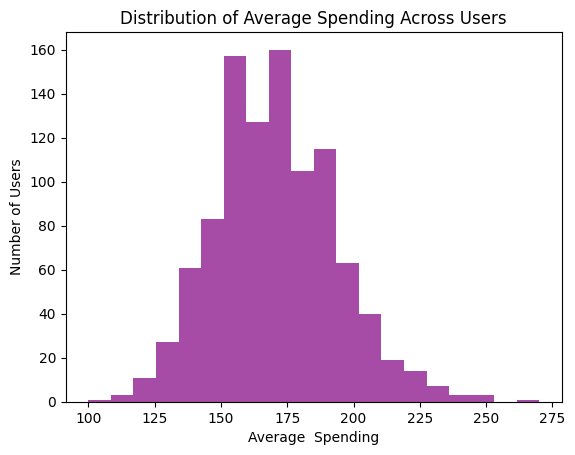

In [24]:
# Average spending for all users
total_quantity_distribution = [sum(item["tot_quantity"] for item in user["details"].values()) for user in users_details]
average_spending_distribution = [total_price // total_quantity for total_price, total_quantity in zip(spending_distribution, total_quantity_distribution)]
print(average_spending_distribution)
# Histogram
plt.hist(average_spending_distribution, bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Average Spending Across Users")
plt.xlabel("Average  Spending")
plt.ylabel("Number of Users")
plt.show()

In [34]:
Total_spending = sum(spending_distribution)
total_average_spending = Total_spending // sum([sum(item["tot_quantity"] for item in user["details"].values()) for user in users_details])
items_set = set()
for user in users_details:
    for item in user["details"]:
        items_set.add(item)
print(f"Total spending: {Total_spending}")
print(f"Total number of users: {len(users_details)}")
print(f"Total number of items: {len(items_set)}")
print(f"Total average spending: {total_average_spending}")

Total spending: 15992074.0
Total number of users: 1000
Total number of items: 8743
Total average spending: 169.0
